# Задача
В наших данных использования ленты новостей есть два типа юзеров: те, кто пришел через платный трафик source = 'ads', и те, кто пришел через органические каналы source = 'organic'.

- Проанализировать и сравнить Retention этих двух групп пользователей. Решением этой задачи будет ответ на вопрос: отличается ли характер использования приложения у этих групп пользователей. 

In [27]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
# Загружаем данные за последние 30 дней
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'-',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = '''
select DISTINCT user_id, 
toDate(time) as time,
       source
      
from {db}.feed_actions 

group by user_id, source, time
having toDate(time) >= today() - 30
'''


df = ph.read_clickhouse(query, connection=connection)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580224 entries, 0 to 580223
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  580224 non-null  uint32        
 1   time     580224 non-null  datetime64[ns]
 2   source   580224 non-null  object        
dtypes: datetime64[ns](1), object(1), uint32(1)
memory usage: 11.1+ MB


In [35]:
df.head()

,user_id,time,source
0,125483,2022-08-18,organic
1,158465,2022-08-18,organic
2,162434,2022-08-23,organic
3,163886,2022-08-12,organic
4,115409,2022-08-17,organic


In [37]:
df['time_new'] = pd.to_datetime(df['time']).dt.date

In [38]:
# Разделяем трафики
df_ads = df[df['source'] == 'ads']
df_ads.head()

,user_id,time,source,time_new
6,63665,2022-08-16,ads,2022-08-16
7,32729,2022-08-09,ads,2022-08-09
9,73038,2022-08-28,ads,2022-08-28
11,71840,2022-08-20,ads,2022-08-20
12,76545,2022-08-28,ads,2022-08-28


In [39]:
df_organic = df[df['source'] == 'organic']
df_organic.head()

,user_id,time,source,time_new
0,125483,2022-08-18,organic,2022-08-18
1,158465,2022-08-18,organic,2022-08-18
2,162434,2022-08-23,organic,2022-08-23
3,163886,2022-08-12,organic,2022-08-12
4,115409,2022-08-17,organic,2022-08-17


In [40]:
# Находим мин дату  ads
min_date_by_ads = df_ads.groupby('user_id', as_index=False)['time_new'].min() \
.rename(columns={'time_new' : 'min_date'})
min_date_by_ads.head() 

,user_id,min_date
0,200,2022-07-30
1,202,2022-07-30
2,203,2022-07-30
3,204,2022-08-02
4,205,2022-08-02


In [66]:
cohort_users_ads = min_date_by_ads.groupby('min_date', as_index=False)['user_id'].nunique()
cohort_users_organic = min_date_by_organic.groupby('min_date', as_index=False)['user_id'].nunique()

In [65]:
# Находим дату первого платежа organic
min_date_by_organic = df_organic.groupby('user_id', as_index=False)['time_new'].min() \
.rename(columns={'time_new' : 'min_date'})
min_date_by_organic.head() 

,user_id,min_date
0,107015,2022-08-03
1,107016,2022-08-13
2,107017,2022-08-06
3,107018,2022-07-30
4,107019,2022-07-31


In [44]:
df_all_ads = df[df['source'] == 'ads']

df_all_organic = df[df['source'] == 'organic']

In [64]:
cohort_users_ads

,min_date,user_id
0,2022-07-30,6986
1,2022-07-31,5626
2,2022-08-01,4615
3,2022-08-02,3524
4,2022-08-03,2980
5,2022-08-04,2443
6,2022-08-05,3176
7,2022-08-06,2829
8,2022-08-07,2480
9,2022-08-08,2422


In [74]:
# ADS
a = df_all_ads.merge(min_date_by_ads, how='inner', on='user_id') \
[['user_id', 'time', 'min_date']] \
.groupby(['time', 'min_date'], as_index='False')['user_id'].nunique().reset_index() \
.rename(columns={'user_id': 'n_active_users_by_ads'}) \
.merge(cohort_users_ads, how='inner', on='min_date') \
.rename(columns={'user_id': 'cohort_users'}) 

In [75]:
a

,time,min_date,n_active_users_by_ads,cohort_users
0,2022-07-30,2022-07-30,6986,6986
1,2022-07-31,2022-07-30,1725,6986
2,2022-08-01,2022-07-30,1527,6986
3,2022-08-02,2022-07-30,1354,6986
4,2022-08-03,2022-07-30,1474,6986
...,...,...,...,...
491,2022-08-28,2022-08-27,484,1378
492,2022-08-29,2022-08-27,435,1378
493,2022-08-28,2022-08-28,1357,1357
494,2022-08-29,2022-08-28,423,1357


In [87]:
# Organic
org = df_all_organic.merge(min_date_by_organic, how='inner', on='user_id') \
[['user_id', 'time', 'min_date']] \
.groupby(['time', 'min_date'], as_index='False')['user_id'].nunique().reset_index() \
.rename(columns={'user_id': 'n_active_users_by_organic'}) \
.merge(cohort_users_organic, how='inner', on='min_date') \
.rename(columns={'user_id': 'cohort_users'}) 
org

,time,min_date,n_active_users_by_organic,cohort_users
0,2022-07-30,2022-07-30,9982,9982
1,2022-07-31,2022-07-30,2886,9982
2,2022-08-01,2022-07-30,2803,9982
3,2022-08-02,2022-07-30,2578,9982
4,2022-08-03,2022-07-30,2551,9982
...,...,...,...,...
491,2022-08-28,2022-08-27,16,110
492,2022-08-29,2022-08-27,14,110
493,2022-08-28,2022-08-28,99,99
494,2022-08-29,2022-08-28,12,99


In [88]:
# Кол-во клиентов по когортам ads
org_pivot = org.pivot_table(
    index='min_date',
    columns='time',
    values='n_active_users_by_organic',
    aggfunc='max',
)
org_pivot

time,2022-07-30,2022-07-31,2022-08-01,2022-08-02,2022-08-03,2022-08-04,2022-08-05,2022-08-06,2022-08-07,2022-08-08,...,2022-08-20,2022-08-21,2022-08-22,2022-08-23,2022-08-24,2022-08-25,2022-08-26,2022-08-27,2022-08-28,2022-08-29
min_date,,,,,,,,,,,,,,,,,,,,,
2022-07-30,9982.0,2886.0,2803.0,2578.0,2551.0,1880.0,2321.0,2350.0,2106.0,2101.0,...,1654.0,1613.0,1536.0,1524.0,1521.0,1575.0,1525.0,1604.0,1491.0,1386.0
2022-07-31,NaN,7434.0,1907.0,1839.0,1789.0,1402.0,1614.0,1626.0,1569.0,1501.0,...,1132.0,1168.0,1144.0,1109.0,1158.0,1097.0,1145.0,1127.0,1183.0,1025.0
2022-08-01,NaN,NaN,5907.0,1566.0,1397.0,1091.0,1362.0,1318.0,1294.0,1244.0,...,962.0,951.0,895.0,888.0,935.0,921.0,849.0,896.0,890.0,786.0
2022-08-02,NaN,NaN,NaN,4365.0,945.0,696.0,894.0,858.0,810.0,776.0,...,631.0,649.0,646.0,657.0,617.0,629.0,618.0,621.0,645.0,532.0
2022-08-03,NaN,NaN,NaN,NaN,3491.0,534.0,699.0,602.0,633.0,583.0,...,511.0,493.0,495.0,451.0,512.0,473.0,477.0,480.0,446.0,415.0
2022-08-04,NaN,NaN,NaN,NaN,NaN,2793.0,697.0,629.0,616.0,567.0,...,384.0,422.0,404.0,387.0,409.0,420.0,426.0,382.0,398.0,372.0
2022-08-05,NaN,NaN,NaN,NaN,NaN,NaN,3270.0,879.0,835.0,866.0,...,511.0,533.0,518.0,506.0,472.0,499.0,496.0,506.0,488.0,423.0
2022-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2818.0,859.0,820.0,...,517.0,511.0,513.0,487.0,481.0,461.0,475.0,424.0,434.0,358.0
2022-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2366.0,616.0,...,425.0,420.0,370.0,388.0,381.0,406.0,351.0,336.0,375.0,320.0


In [49]:
# Кол-во клиентов по когортам ads
ads_pivot= a.pivot_table(
    index='min_date',
    columns='time',
    values='n_active_users_by_ads',
    aggfunc='max',
)
ads_pivot

time,2022-07-30,2022-07-31,2022-08-01,2022-08-02,2022-08-03,2022-08-04,2022-08-05,2022-08-06,2022-08-07,2022-08-08,...,2022-08-20,2022-08-21,2022-08-22,2022-08-23,2022-08-24,2022-08-25,2022-08-26,2022-08-27,2022-08-28,2022-08-29
min_date,,,,,,,,,,,,,,,,,,,,,
2022-07-30,6986.0,1725.0,1527.0,1354.0,1474.0,1035.0,1233.0,1205.0,1074.0,975.0,...,621.0,624.0,593.0,625.0,623.0,580.0,569.0,581.0,614.0,526.0
2022-07-31,NaN,5626.0,1201.0,1161.0,1074.0,769.0,887.0,901.0,851.0,807.0,...,471.0,512.0,498.0,455.0,493.0,479.0,474.0,471.0,469.0,409.0
2022-08-01,NaN,NaN,4615.0,982.0,906.0,692.0,746.0,788.0,704.0,686.0,...,426.0,411.0,394.0,398.0,370.0,364.0,380.0,368.0,382.0,307.0
2022-08-02,NaN,NaN,NaN,3524.0,525.0,393.0,477.0,481.0,438.0,449.0,...,299.0,276.0,309.0,287.0,285.0,292.0,259.0,296.0,264.0,262.0
2022-08-03,NaN,NaN,NaN,NaN,2980.0,345.0,403.0,383.0,339.0,329.0,...,244.0,244.0,250.0,218.0,238.0,243.0,224.0,213.0,211.0,197.0
2022-08-04,NaN,NaN,NaN,NaN,NaN,2443.0,469.0,376.0,390.0,374.0,...,201.0,207.0,222.0,197.0,205.0,196.0,204.0,210.0,186.0,164.0
2022-08-05,NaN,NaN,NaN,NaN,NaN,NaN,3176.0,623.0,589.0,578.0,...,337.0,327.0,325.0,286.0,298.0,279.0,292.0,283.0,236.0,213.0
2022-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2829.0,655.0,657.0,...,315.0,317.0,294.0,271.0,286.0,283.0,267.0,262.0,253.0,216.0
2022-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2480.0,530.0,...,297.0,288.0,305.0,244.0,254.0,240.0,220.0,202.0,225.0,171.0


In [81]:
# Считаем Retention ads
a['retention'] = a['n_active_users_by_ads']/a['cohort_users'] 

In [91]:
# Считаем Retention ads
org['retention'] = org['n_active_users_by_organic']/org['cohort_users'] 

In [82]:
a

,time,min_date,n_active_users_by_ads,cohort_users,retention
0,2022-07-30,2022-07-30,6986,6986,1.000000
1,2022-07-31,2022-07-30,1725,6986,0.246922
2,2022-08-01,2022-07-30,1527,6986,0.218580
3,2022-08-02,2022-07-30,1354,6986,0.193816
4,2022-08-03,2022-07-30,1474,6986,0.210993
...,...,...,...,...,...
491,2022-08-28,2022-08-27,484,1378,0.351234
492,2022-08-29,2022-08-27,435,1378,0.315675
493,2022-08-28,2022-08-28,1357,1357,1.000000
494,2022-08-29,2022-08-28,423,1357,0.311717


In [92]:
org

,time,min_date,n_active_users_by_organic,cohort_users,retention
0,2022-07-30,2022-07-30,9982,9982,1.000000
1,2022-07-31,2022-07-30,2886,9982,0.289120
2,2022-08-01,2022-07-30,2803,9982,0.280805
3,2022-08-02,2022-07-30,2578,9982,0.258265
4,2022-08-03,2022-07-30,2551,9982,0.255560
...,...,...,...,...,...
491,2022-08-28,2022-08-27,16,110,0.145455
492,2022-08-29,2022-08-27,14,110,0.127273
493,2022-08-28,2022-08-28,99,99,1.000000
494,2022-08-29,2022-08-28,12,99,0.121212


In [83]:
# Cводная по Retention ads
ads_retention = a.pivot_table(
    index='min_date',
    columns='time',
    values='retention',
    aggfunc='sum',
) 

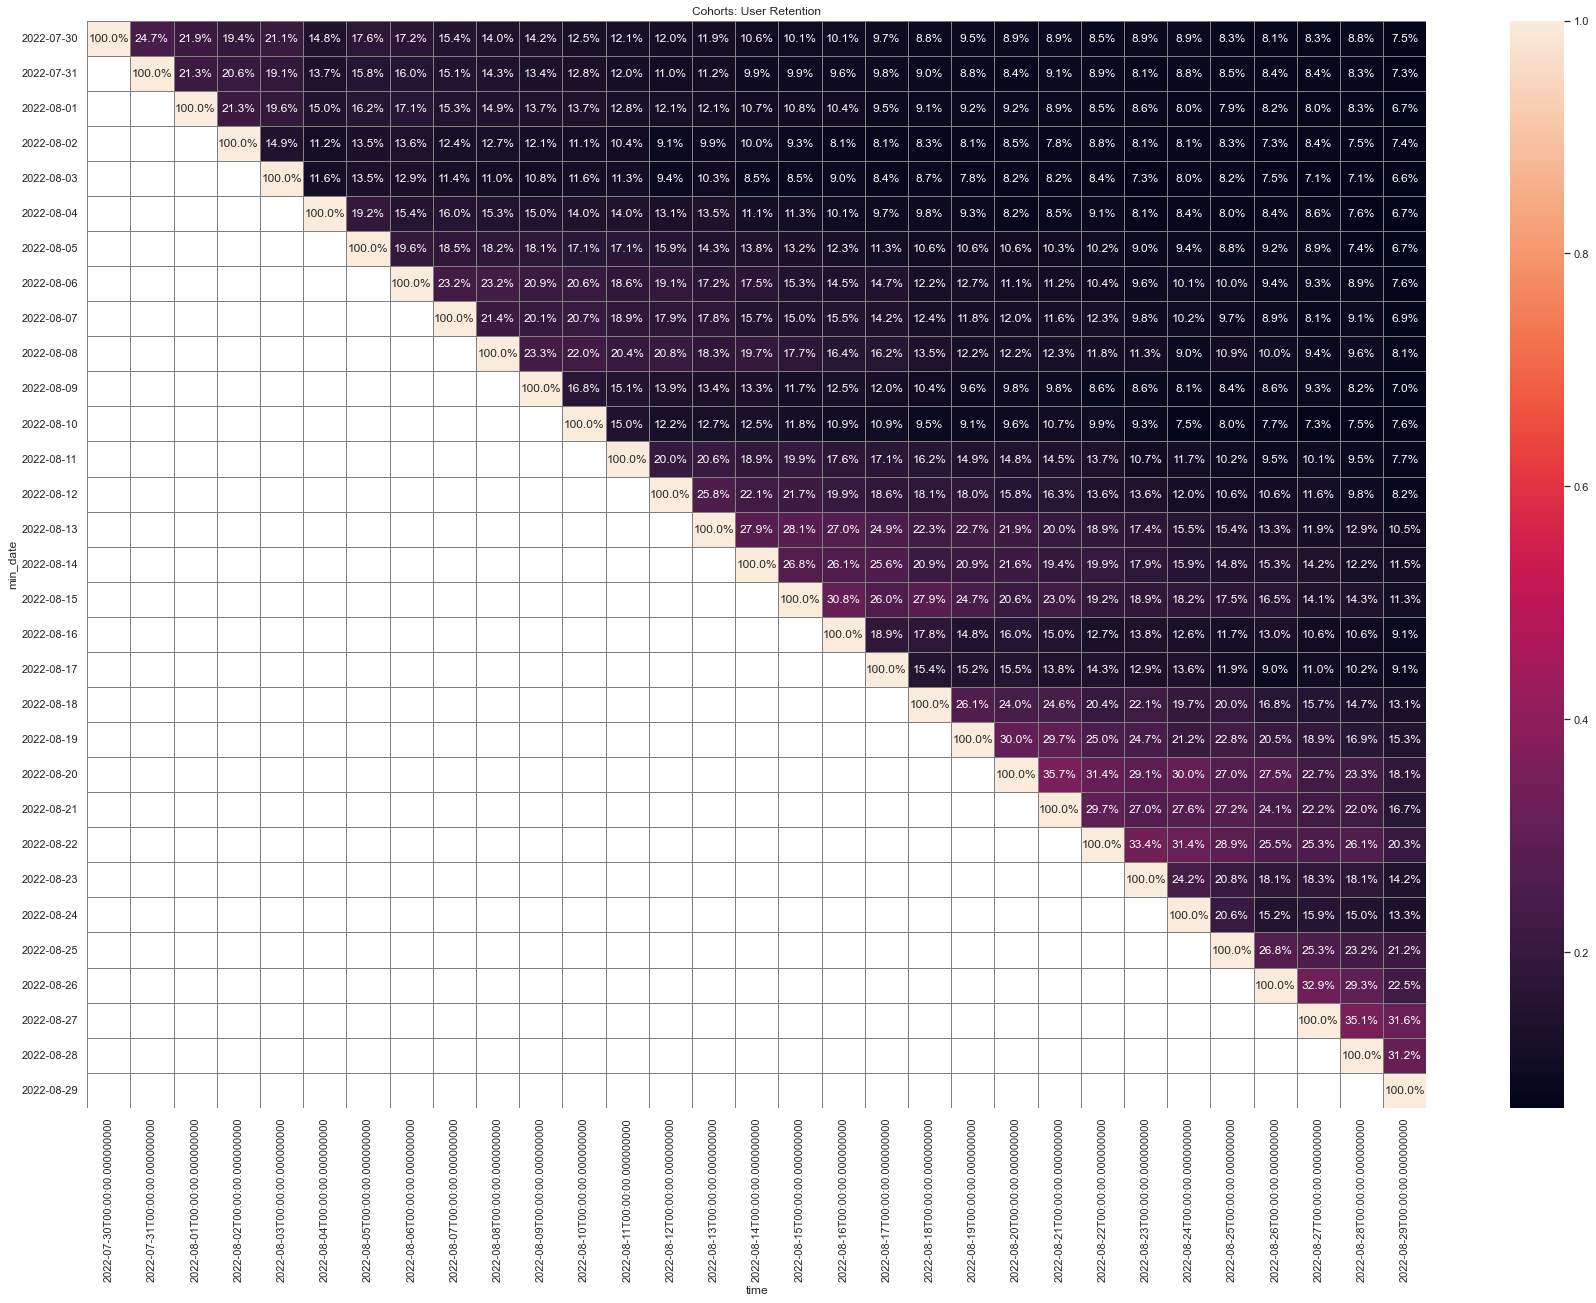

In [85]:
# Тепловая карта по ads
sns.set(style='white')
plt.figure(figsize=(30, 20))
plt.title('Cohorts: User Retention')
sns.heatmap(ads_retention, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

In [93]:
# Cводная по Retention organic
org_retention = org.pivot_table(
    index='min_date',
    columns='time',
    values='retention',
    aggfunc='sum',
) 

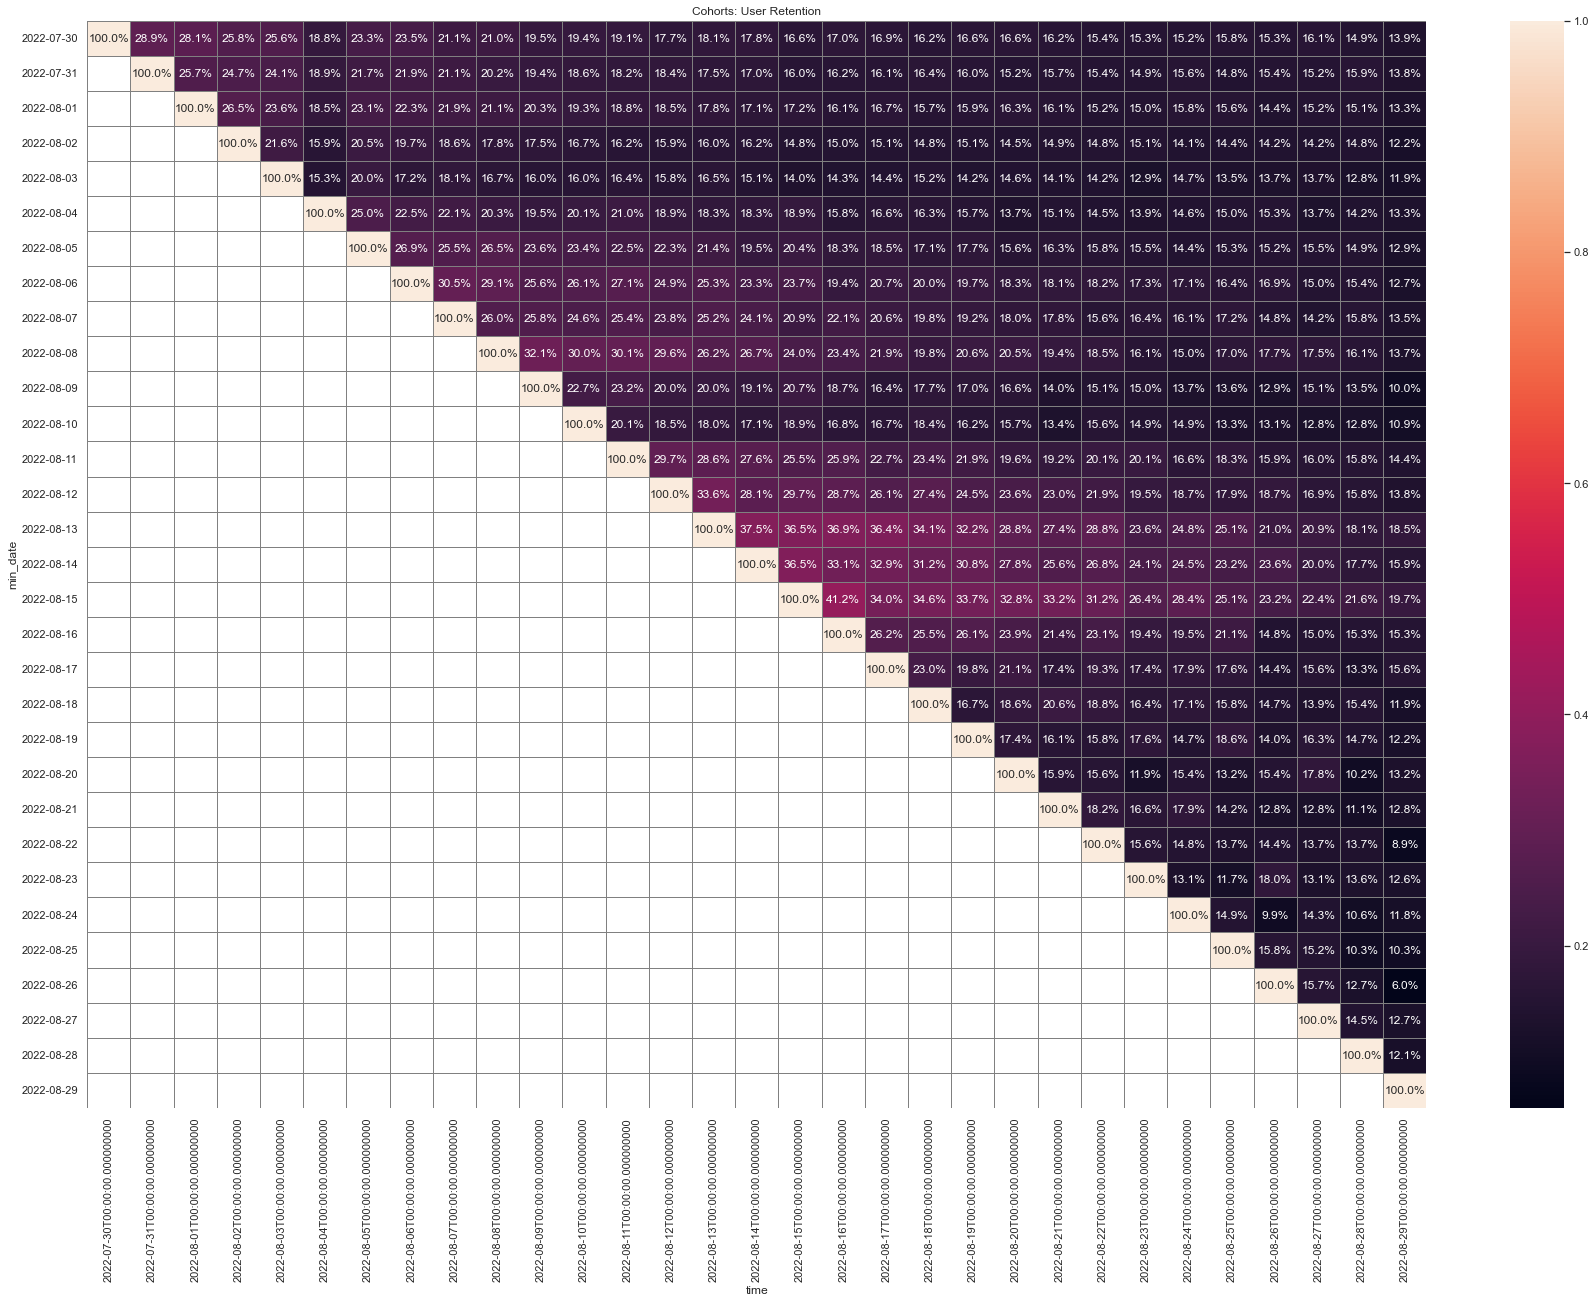

In [94]:
# Тепловая карта по organic
sns.set(style='white')
plt.figure(figsize=(30, 20))
plt.title('Cohorts: User Retention')
sns.heatmap(org_retention, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

# Вывод
Retention по organic выше, чем Retention у ads. Это означает, что по платным каналам приходят почти столько же, сколько и по органик, а вот остается по органик на 6% больше клиентов.
Возможно, реклама направлена не на ту ЦА, и люди приходят не с выявленной потребностью, а любопытства ради.
Рекомендую маркетологам пересмотреть таргетирование ЦА.

In [121]:
450/500*0.95 + 50/500*0.03

0.858

In [126]:
1/500*0.9

0.0018000000000000002